# [Angle closure Glaucoma Evaluation Challenge](https://age.grand-challenge.org/Details/)
## Scleral spur localization Baseline （ResNet50+UNet)

- To keep model training stable, images with coordinate == -1, were removed.

- For real inference, you MIGHT keep all images in val_file_path file.

## Result Visualization

- output_file do not contain coordinates==-1 images
- Due to the preprocessing step
- For real inference, keep all images in val_data_list.

In [1]:
import os, random, functools, math
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as FL
import paddle.fluid.optimizer as FO
fluid.install_check.run_check()

Running Verify Fluid Program ... 
Your Paddle Fluid works well on SINGLE GPU or CPU.
Your Paddle Fluid works well on MUTIPLE GPU or CPU.
Your Paddle Fluid is installed successfully! Let's start deep Learning with Paddle Fluid now


In [3]:
BATCH_SIZE = 8
THREAD = 8
BUF_SIZE = 32

In [4]:
# preprocess: extract left/right label col in Training100_Location.xlsx
# save to train_csv file
data_root_path = "../datasets/Training100/"
image_path = os.path.join(data_root_path, "ASOCT_Image_loc")
origin_data_dir = os.path.join(data_root_path, "ASOCT_Image")

# !!!For real inference, keep all images in val_file_path file!!!
val_file_path = os.path.join(data_root_path, "loc_val_split.csv")
output_file = "./Localization_Results.csv"

In [5]:
# Remove last global pooling and fullyconnect layer to enable UNet arch.
# Standard ResNet Implement: 
# https://github.com/PaddlePaddle/models/blob/develop/PaddleCV/image_classification/models/resnet.py
from resnet import *
from res_unet_paddle import *

In [6]:
def gaussian_k(x0,y0, sigma, width, height):
    """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
    """
    x = np.arange(0, width, 1, float) ## (width,)
    y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width, point, s=10):
    """ Generate a full Heap Map for every landmarks in an array
    Args:
        height    : The height of Heat Map (the height of target output)
        width     : The width  of Heat Map (the width of target output)
        point    : (x,y)
    """
    hm = gaussian_k(point[0], point[1], s, height, width)
    return hm

In [7]:
def reader(img_path, file_list, batch_size=32, shuffle=True, shuffle_seed=42):
    def read_file_list():
        batch_data = []
        np.random.shuffle(file_list)
        for line in file_list:
            file_name, p_x, p_y = line.split(",")
            batch_data.append([file_name, float(p_x), float(p_y)])
            if len(batch_data) == batch_size:
                yield batch_data
                batch_data = []
        if len(batch_data) != 0:
            yield batch_data
    return read_file_list

def process_batch_data(input_data):
    batch_data = []
    for sample in input_data:
        file, p_x, p_y = sample
        
        img = cv2.imread( file )
        img = img[:, :, ::-1].astype('float32') / 255.0
        
        ratio = 256.0 / img.shape[0]
        img = cv2.resize(img, (256, 256))
        
        hm = generate_hm(256, 256, (p_x * ratio, p_y * ratio))

        img = img.transpose((2, 0, 1))
        batch_data.append((img, file, (p_x, p_y)))

    return batch_data

In [8]:
def data_loader(img_list, img_path, batch_size, order=False):
    data_reader = reader(img_path, img_list, batch_size)
    mapper = functools.partial(process_batch_data)
    
    data_reader = paddle.reader.shuffle(data_reader, 32)
    
    return paddle.reader.xmap_readers(
        mapper, data_reader, THREAD, BUF_SIZE, order=order)
        
with open(val_file_path) as flist:
    val_file_list = [os.path.join(image_path,line.strip()) for line in flist]  

val_dataloader = data_loader(val_file_list, image_path, BATCH_SIZE, True)

In [9]:
def network():
    data_shape = [3, 256, 256]
    
    model = ResUNet(
        ResNet50().net, 1
    )
    
    input_feature = FL.data(name='pixel', shape=data_shape, dtype='float32')
    
    logit = model.net(input_feature)
    pred_hm = FL.squeeze(logit, axes=[1]) # Bs, 256,256

    return pred_hm

In [10]:
def calc_dist(pred_hm, points, ratio=1.0):
    dis_arr = []
    pred_idx = []
    for point, single_pred_hm in zip(points, pred_hm):
        label_y, label_x = point
        pred_x, pred_y = np.unravel_index(single_pred_hm.argmax(), single_pred_hm.shape)
        pred_x, pred_y = pred_x * ratio, pred_y * ratio
        dis_arr.append( np.sqrt((pred_x - label_x) ** 2 + (pred_y - label_y) ** 2))
        pred_idx.append((pred_y, pred_x))
    
    return np.array(dis_arr), pred_idx

In [11]:
def infer(use_cuda, pretrained_model):
    place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
    
    startup_prog = fluid.Program()
    val_prog = fluid.Program()
    
    # 定义预测网络
    with fluid.program_guard(val_prog, startup_prog):
        # Use fluid.unique_name.guard() to share parameters with train network
        with fluid.unique_name.guard():
            val_output = network()

    val_prog = val_prog.clone(for_test=True)
    val_output.persistable = True
            
    exe = fluid.Executor(place)
    exe.run(startup_prog)

    if pretrained_model:
        def if_exist(var):
            return os.path.exists(os.path.join(pretrained_model, var.name))

        fluid.io.load_vars(
            exe, pretrained_model, main_program=val_prog, predicate=if_exist)

    file_names, points, pred_hms = [],[],[]

    for tid, val_data in enumerate(val_dataloader()):
        imgs = []
        for item in val_data:
            imgs.append(item[0])
            file_names.append(item[1])
            points.append(item[2])
            
        batch_pred_hm, = exe.run(
            program=val_prog,
            feed={"pixel":np.array(imgs)},
            fetch_list=[val_output],
            use_program_cache=True)
        pred_hms.append(batch_pred_hm)

    pred_hms = np.concatenate(pred_hms, 0)

    return file_names, np.array(points), pred_hms

In [12]:
file_names, points, pred_hms = \
        infer(use_cuda=True, pretrained_model="../weights/loc_unet_best")

print(pred_hms.shape)
print(points.shape)

ratio = 998. / 256. # all cropped images have same shape
dis, pred_idx = calc_dist(pred_hms, points, ratio)
print(dis.shape)

(607, 256, 256)
(607, 2)
(607,)


In [13]:
print("Minimum Distance: {:.2f}, idx: {}".format(dis.min(), dis.argmin()))
print("Maximum Distance: {:.2f}, idx: {}".format(dis.max(), dis.argmax()))
print("Average Distance: {:.2f}".format(dis.mean()))

Minimum Distance: 0.61, idx: 42
Maximum Distance: 62.52, idx: 420
Average Distance: 14.96


Text(0, 0.5, 'Number')

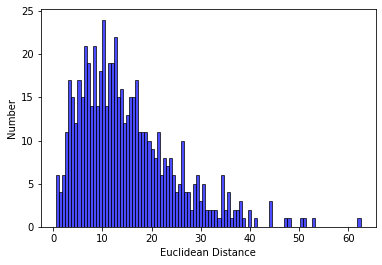

In [14]:
_ = plt.hist(dis, bins=100, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Euclidean Distance")
plt.ylabel("Number")

Good Case


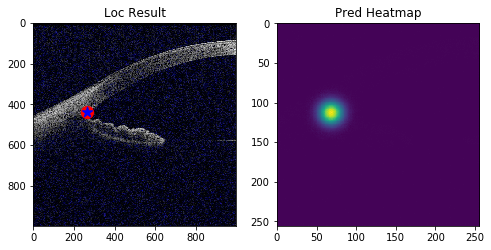

In [15]:
print("Good Case")
plt.figure(figsize=(8,5))

idx = dis.argmin()

img = cv2.imread(file_names[idx])[:,:,::-1]

plt.subplot(1,2,1)
plt.title("Loc Result")
plt.imshow(img)
plt.scatter(*points[idx], c='r', s=150)
plt.scatter(*pred_idx[idx], c='b', s=120, marker='*')

plt.subplot(1,2,2)
plt.title("Pred Heatmap")
plt.imshow(pred_hms[idx])

Bad Case
../datasets/Training100/ASOCT_Image_loc/T0035-09_left.jpg


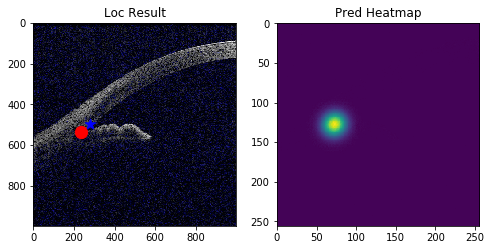

In [16]:
print("Bad Case")

plt.figure(figsize=(8,5))

idx = dis.argmax()
print(file_names[idx])

img = cv2.imread(file_names[idx])[:,:,::-1]

plt.subplot(1,2,1)
plt.title("Loc Result")
plt.imshow(img)
plt.scatter(*points[idx], c='r', s=150)
plt.scatter(*pred_idx[idx], c='b', s=120, marker='*')

plt.subplot(1,2,2)
plt.title("Pred Heatmap")
plt.imshow(pred_hms[idx])

In [17]:
result = {}
for file, pred_id in zip(file_names, pred_idx):
    # T0055-15_right.jpg -> T0055-15
    ori_name = file.split("/")[-1].split("_")[0]
    if ori_name not in result.keys():
        result[ori_name] = [[-1, -1],[-1, -1]]

    if "left" in file: result[ori_name][0] = pred_id
    else: 
        image = cv2.imread(os.path.join(origin_data_dir, ori_name+".jpg"))
        nrows, ncols, ch = image.shape
        result[ori_name][1] = [(ncols - nrows) + pred_id[0], pred_id[1]]

In [18]:
# output_file do not contain coordinates==-1 images
# Due to the preprocessing step
# For real inference, keep all images in val_data_list.

with open(output_file, "w+") as f:
    f.write("{},{},{},{},{}\n".format("ASOCT_NAME", "X_LEFT", "Y_LEFT", "X_RIGHT", "Y_RIGHT"))
    for file, pred_point in result.items():
        f.write("{},{},{},{},{}\n".format(file+".jpg", *pred_point[0], *pred_point[1]))